In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.callbacks import EarlyStopping, History
from nltk.corpus import stopwords
import string

# Load the data
data = pd.read_csv('news-article-categories.csv', encoding='latin-1')
data.sample(10)

C:\Users\dadiw\AppData\Local\Temp\ipykernel_23608\3492019641.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


,category,title,body
5824,SPORTS,Yankees' Derek Jeter Ceremony Spurs Memories O...,When Derek Jeter spoke to fans at Yankee Stadi...
3170,ENTERTAINMENT,'Trading Spaces' Brings High Stakes Back To Ho...,In the premiere episode of the revived âTrad...
2074,CRIME,Alleged Airplane Smoker Threatens To 'Kill Eve...,Video taken from a weekend flight shows a woma...
42,ARTS & CULTURE,"As Trump's Scandals Mount, Filmmakers Gravitat...","In the year since Donald Trumpâs election, A..."
3089,ENTERTAINMENT,New 'Jurassic World: Fallen Kingdom' Trailer H...,The final âJurassic World: Fallen Kingdomâ...
2132,CRIME,Pastor Accused Of Impersonating Cop And Assaul...,"Itâs a sin to bear false witness, but that d..."
5350,SCIENCE,Your Birthday May Play A Role In Whether You S...,Scientists have long noticed a strange correla...
6074,TECH,Snapchat Files For IPO That Would Be Biggest I...,Snapchat has filed for an initial public offer...
6164,TECH,"Polaroid Launches A New App, And It's Not What...",This isnât your grandpaâs Polaroid. The fa...
54,ARTS & CULTURE,Chinese Museum Removes Photo Series Comparing ...,A series of photographs by Chinese artist Yu H...


In [2]:
data['category'].unique()

array(['ARTS & CULTURE', 'BUSINESS', 'COMEDY', 'CRIME', 'EDUCATION',
       'ENTERTAINMENT', 'ENVIRONMENT', 'MEDIA', 'POLITICS', 'RELIGION',
       'SCIENCE', 'SPORTS', 'TECH', 'WOMEN'], dtype=object)

In [3]:
# Encode the categories
label_encoder = preprocessing.LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])
data['category'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [4]:
# Define a function to process text
def text_process(text):
    if isinstance(text, float) and np.isnan(text):
        return ""
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

# Apply text processing to title and body
data['title'] = data['title'].apply(text_process)
data['body'] = data['body'].apply(text_process)

# Combine title and body into a single feature
data['combined_text'] = data['title'] + ' ' + data['body']

In [5]:
# Convert text to vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['combined_text'])

# Scale features using MinMaxScaler
minmax_scaler = preprocessing.MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X_tfidf.toarray())

# Combine scaled features with labels
X_combined = np.column_stack((X_scaled, data['category']))

In [6]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined, data['category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled[:, :-1],  # Features
    X_resampled[:, -1],   # Labels
    test_size=0.2,
    random_state=42
)

# Convert labels to categorical one-hot encoding
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Reshape input data for RNN
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [7]:
import tensorflow as tf  # Add this line to import TensorFlow

# Define a custom callback to capture training history
class TrainingHistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history[key].append(value)

In [8]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # Add the first SimpleRNN layer
    model.add(SimpleRNN(units=hp.Int('units1', min_value=32, max_value=128, step=32),
                        input_shape=(1, X_train.shape[1]),
                        activation=hp.Choice('activation1', values=['relu', 'tanh','sigmoid']),
                        return_sequences=True))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Add more SimpleRNN layers (you can customize the number and configuration)
    for i in range(hp.Int('num_rnn_layers', min_value=1, max_value=3)):
        model.add(SimpleRNN(units=hp.Int(f'units_rnn_{i}', min_value=32, max_value=128, step=32),
                            activation=hp.Choice(f'activation_rnn_{i}', values=['relu', 'tanh','sigmoid']),
                            return_sequences=True))
        model.add(Dropout(hp.Float(f'dropout_rnn_{i}', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Flatten the output before Dense layers
    model.add(Flatten())
    
    # Add Dense layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3)):
        model.add(Dense(hp.Int(f'units_dense_{i}', min_value=16, max_value=64, step=16),
                        activation=hp.Choice(f'activation_dense_{i}', values=['relu', 'tanh','sigmoid'])))
        model.add(Dropout(hp.Float(f'dropout_dense_{i}', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # You can increase this value for a more comprehensive search
    directory='my_dirX',
    project_name='rnn_tuning'
)

# Create an instance of the custom callback
history_callback = TrainingHistoryCallback()

# Search for the best hyperparameters
tuner.search(X_train_rnn, y_train_one_hot, epochs=50, validation_split=0.1, batch_size=32, callbacks=[early_stopping,history_callback])

# Get the best model
best_model = tuner.get_best_models(1)[0]

# Evaluate the best model on the test set
y_pred_one_hot = best_model.predict(X_test_rnn)
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Evaluate the model
print("Best Hyperparameters:", tuner.oracle.get_best_trials()[0].hyperparameters.values)
print("Best Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Reloading Tuner from my_dirX\rnn_tuning\tuner0.json


88/88 [==============================] - 2s 10ms/step
Best Hyperparameters: {'units1': 128, 'activation1': 'relu', 'dropout1': 0.30000000000000004, 'num_rnn_layers': 3, 'units_rnn_0': 96, 'activation_rnn_0': 'relu', 'dropout_rnn_0': 0.30000000000000004, 'num_dense_layers': 1, 'units_dense_0': 48, 'activation_dense_0': 'relu', 'dropout_dense_0': 0.2, 'units_dense_1': 32, 'activation_dense_1': 'tanh', 'dropout_dense_1': 0.30000000000000004, 'units_dense_2': 48, 'activation_dense_2': 'tanh', 'dropout_dense_2': 0.2, 'units_rnn_1': 32, 'activation_rnn_1': 'tanh', 'dropout_rnn_1': 0.30000000000000004, 'units_rnn_2': 32, 'activation_rnn_2': 'relu', 'dropout_rnn_2': 0.2}
Best Accuracy: 0.9493941553813258
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.80      0.88       205
         1.0       0.92      0.92      0.92       204
         2.0       0.95      0.96      0.95       212

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dropout, Flatten, Dense
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.metrics import accuracy_score, classification_report

# # Specify hyperparameters
# hyperparameters = {
#     'units1': 128,
#     'activation1': 'relu',
#     'dropout1': 0.3,
#     'num_rnn_layers': 3,
#     'units_rnn_0': 96,
#     'activation_rnn_0': 'relu',
#     'dropout_rnn_0': 0.3,
#     'units_rnn_1': 32,
#     'activation_rnn_1': 'tanh',
#     'dropout_rnn_1': 0.3,
#     'units_rnn_2': 32,
#     'activation_rnn_2': 'relu',
#     'dropout_rnn_2': 0.2,
#     'num_dense_layers': 1,
#     'units_dense_0': 48,
#     'activation_dense_0': 'relu',
#     'dropout_dense_0': 0.2,
#     'units_dense_1': 32,
#     'activation_dense_1': 'tanh',
#     'dropout_dense_1': 0.3,
#     'units_dense_2': 48,
#     'activation_dense_2': 'tanh',
#     'dropout_dense_2': 0.2
# }

# # Build the model
# model = Sequential()

# # Add the first SimpleRNN layer
# model.add(SimpleRNN(units=hyperparameters['units1'],
#                     input_shape=(1, X_train.shape[1]),
#                     activation=hyperparameters['activation1'],
#                     return_sequences=True))
# model.add(Dropout(hyperparameters['dropout1']))

# # Add more SimpleRNN layers
# for i in range(hyperparameters['num_rnn_layers']):
#     model.add(SimpleRNN(units=hyperparameters[f'units_rnn_{i}'],
#                         activation=hyperparameters[f'activation_rnn_{i}'],
#                         return_sequences=True))
#     model.add(Dropout(hyperparameters[f'dropout_rnn_{i}']))

# # Flatten the output before Dense layers
# model.add(Flatten())

# # Add Dense layers
# for i in range(hyperparameters['num_dense_layers']):
#     model.add(Dense(units=hyperparameters[f'units_dense_{i}'],
#                     activation=hyperparameters[f'activation_dense_{i}']))
#     model.add(Dropout(hyperparameters[f'dropout_dense_{i}']))

# # Output layer
# model.add(Dense(num_classes, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Train the model and track accuracy history
# history = model.fit(X_train_rnn, y_train_one_hot, epochs=50, validation_split=0.1, batch_size=32, callbacks=[early_stopping])

# # Get training and validation accuracy from the history
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# # Plot training accuracy
# plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
# plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Evaluate the model on the test set
# y_pred_one_hot = model.predict(X_test_rnn)
# y_pred = np.argmax(y_pred_one_hot, axis=1)

# # Evaluate the model
# print("Best Hyperparameters:", hyperparameters)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

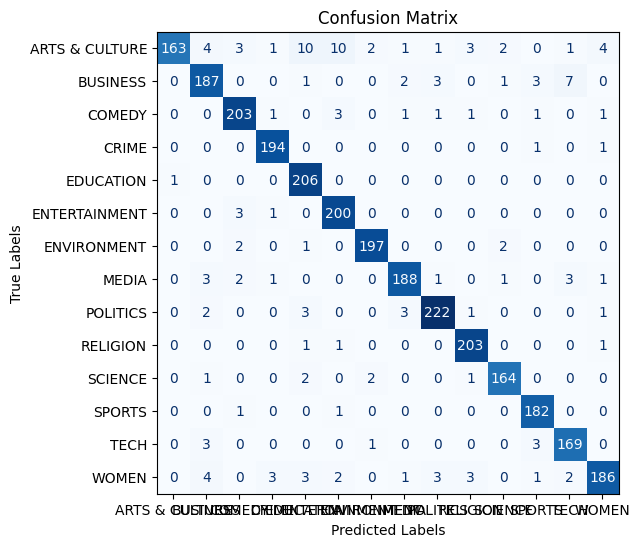

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ... (previous code)

# Define the class labels
class_labels = ['ARTS & CULTURE', 'BUSINESS', 'COMEDY', 'CRIME', 'EDUCATION', 'ENTERTAINMENT', 
                'ENVIRONMENT', 'MEDIA', 'POLITICS', 'RELIGION', 'SCIENCE', 'SPORTS', 'TECH', 'WOMEN']

# Plot Confusion Matrix using Seaborn with string labels
conf_matrix = confusion_matrix(y_test, y_pred)

# Create ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix with predicted labels on the horizontal axis
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="horizontal", colorbar=False)
ax.set_xticks(np.arange(len(class_labels)))
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
plt.title('Confusion Matrix')
plt.show()


In [12]:
X_resampled.shape

(14028, 110799)

In [13]:
y_resampled.shape

(14028,)

In [14]:
14028*0.20

2805.6000000000004

In [15]:
14028*0.80

11222.400000000001

In [16]:
import joblib

# Save TF-IDF Vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

# Save MinMaxScaler
joblib.dump(minmax_scaler, 'minmax_scaler.joblib')

# Save the best model
best_model.save('best_model.h5')


c:\Users\dadiw\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string

# Function to process text
def text_process(text):
    if isinstance(text, float) and np.isnan(text):
        return ""
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

# Load TF-IDF Vectorizer and MinMaxScaler
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')
minmax_scaler = joblib.load('minmax_scaler.joblib')

# Load the Best Model
best_model = load_model('best_model.h5')

# Sample new data (replace this with your new data)
new_data = pd.DataFrame({
    'title': ['Actor Jeff Hiller Talks â€œBright Colors And Bold Patternsâ€ and More (AUDIO)'],
    'body' : ['This week I talked with actor Jeff Hiller about the hit Off Broadway play Bright Colors And Bold Patterns that heâ€™ll be joining on January 17th with a new opening night scheduled for February 4th. Hiller (Nightcap, 30 Rock & Broadwayâ€™s Bloody Bloody Andrew Jackson) will step into the starring role of this devastatingly funny hit play directed by Michael Urie (Torch Song, Buyer & Cellar, Ugly Betty) and written by Drew Droege the playâ€™s original star. Hiller will continue the playâ€™s triumphant Off Broadway run through February 25th at the SoHo Playhouse in NYC. Bright Colors And Bold Patterns is about Josh and Brennan who are about to get married in Palm Springs on a lovely Saturday afternoon. However, the night before becomes a drunken, drug-fueled riot because their friend Gerry arrives furious that their invitation says: â€œPlease refrain from wearing bright colors or bold patterns.â€ The play is produced by Zach Laks in association with Riki Kane Larimer and features set design by Dara Wishingrad. Tom DeTrinis serves as associate producer. Bright Colors And Bold Patterns was originally presented at VS Theatre in Los Angeles and directed by Molly Prather. I talked to Jeff about how thrilled he is to perform Drew Droegeâ€™s hysterical one man show and his spin on our LGBTQ issues. LISTEN: Â  When asked how he sees our LGBTQ community moving forward in this Trump administration Hiller stated: Jeff Hiller is a regular performer at the UCB Theatre in both New York City and Los Angeles. Jeff has also written and starred in a pilot for Universal Cable Productions as well as acting in pilots for NBC, Fox, and CBS. He will step in the role of Gerry in the hit Off Broadway playÂ Bright Colors And Bold PatternsÂ starting on January 17th at the SoHo Playhouse in NYC. For Info & Tix: brightcolorsandboldpatterns.com Listen to more LGBT Leaders, Allies & Celebrity Podcasts: OUTTAKE VOICESâ„¢ Download Podcasts on iTunes']
})

# Apply the same text processing as during training
new_data['title'] = new_data['title'].apply(text_process)
new_data['body'] = new_data['body'].apply(text_process)
new_data['combined_text'] = new_data['title'] + ' ' + new_data['body']

# Use the loaded TF-IDF Vectorizer and MinMaxScaler
X_new_tfidf = tfidf_vectorizer.transform(new_data['body'])
X_new_scaled = minmax_scaler.transform(X_new_tfidf.toarray())

# Reshape input data for RNN
X_new_rnn = X_new_scaled.reshape((X_new_scaled.shape[0], 1, X_new_scaled.shape[1]))

# Make predictions using the loaded model
y_pred_one_hot = best_model.predict(X_new_rnn)
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Now, y_pred contains the predicted labels for your new data
print("Predicted Labels:", y_pred)


1/1 [==============================] - 1s 1s/step
Predicted Labels: [0]
